In [1]:
import pickle
import sys
import numpy as np
from pathlib import Path

# 1. SETUP PATHS
# Use pathlib to safely find the file relative to the 'notebooks' folder
file_path = Path('..') / 'data' / 'raw' / 'crystal_graphs_dataset.pkl'
print(f"Attempting to load: {file_path.resolve()}")

# 2. DEFINE DUMMY CLASSES (The "Safety Net")
# If the pickle file looks for 'CrystalGraphDataset' or 'Graph' and can't find them,
# it will use this Placeholder class instead of crashing.
class Placeholder:
    def __init__(self, *args, **kwargs): pass
    def __setstate__(self, state): self.__dict__ = state

# Inject placeholders into the main namespace
if not hasattr(sys.modules['__main__'], 'CrystalGraphDataset'):
    setattr(sys.modules['__main__'], 'CrystalGraphDataset', Placeholder)
if not hasattr(sys.modules['__main__'], 'Graph'):
    setattr(sys.modules['__main__'], 'Graph', Placeholder)

# 3. LOAD THE DATA
try:
    with open(file_path, 'rb') as f:
        loaded_data = pickle.load(f)
    print("✅ Success: File loaded!")
except Exception as e:
    print(f"❌ Error loading file: {e}")
    raise e

# 4. INSPECT THE STRUCTURE
# We need to know exactly how nodes and edges are stored to write the next script.
if isinstance(loaded_data, dict):
    graphs = loaded_data.get('graphs', [])
    metadata = loaded_data.get('metadata', [])
    print(f"\nDataset contains {len(graphs)} graphs and {len(metadata)} metadata entries.")
    
    if len(graphs) > 0:
        g0 = graphs[0]
        print(f"\n--- GRAPH 0 STRUCTURE ---")
        print(f"Object Type: {type(g0)}")
        
        # Check Node Features (CRITICAL for Discretization)
        if hasattr(g0, 'nodes'):
            nodes = g0.nodes
            print(f"1. .nodes type: {type(nodes)}")
            
            # If list, print first element
            if isinstance(nodes, list) and len(nodes) > 0:
                feat = nodes[0]
                print(f"2. Node[0] Data: {feat}")
                print(f"3. Node[0] Type: {type(feat)}")
                if isinstance(feat, np.ndarray):
                    print(f"4. Feature shape: {feat.shape}")
            # If dict, print first key-value
            elif isinstance(nodes, dict) and len(nodes) > 0:
                first_key = list(nodes.keys())[0]
                print(f"2. Node[{first_key}] Data: {nodes[first_key]}")
        else:
            print("⚠️ Graph object has no '.nodes' attribute.")

        # Check Edges (CRITICAL for Subgraph Extraction)
        if hasattr(g0, 'edges'):
            edges = g0.edges
            print(f"5. .edges type: {type(edges)}")
            if hasattr(edges, '__iter__') and len(edges) > 0:
                print(f"6. Sample Edge: {list(edges)[0]}")
        elif hasattr(g0, 'adj'):
            print(f"5. Graph uses adjacency list (.adj) instead of .edges")
        else:
            print("⚠️ Graph object has no '.edges' attribute.")
            
        # Check Metadata
        if len(metadata) > 0:
            print(f"\n--- METADATA SAMPLE ---")
            print(metadata[0])
else:
    print(f"Unexpected data structure: {type(loaded_data)}")

Attempting to load: C:\Users\ritib\OneDrive - Umich\Classes\ML Project\553ProjectGraphKernels\data\raw\crystal_graphs_dataset.pkl
✅ Success: File loaded!

Dataset contains 132 graphs and 132 metadata entries.

--- GRAPH 0 STRUCTURE ---
Object Type: <class 'networkx.classes.graph.Graph'>
1. .nodes type: <class 'networkx.classes.reportviews.NodeView'>
5. .edges type: <class 'networkx.classes.reportviews.EdgeView'>
6. Sample Edge: (0, 1)

--- METADATA SAMPLE ---
{'crystal_type': 'sc', 'noise_level': 0.0, 'sample_idx': 0, 'n_nodes': 3375, 'n_edges': 10125, 'system_size': 15, 'scale_factor': 1.0, 'ls': (4, 5, 6, 8, 10, 12), 'weight_threshold': 0.05, 'cutoff': 1.8}


In [2]:
import pickle
import random
import networkx as nx
import numpy as np
import os
import sys, os
sys.path.append(os.path.abspath(".."))

from pathlib import Path
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split, StratifiedGroupKFold
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from grakel import Graph
from grakel.kernels import WeisfeilerLehmanOptimalAssignment
from src.processing import process_graphs


# --- CONFIGURATION ---
# Path logic: Go up one level from 'notebooks' to find 'data'
RAW_DATA_PATH = Path('..') / 'data' / 'raw' / 'crystal_graphs_dataset.pkl'

# Preprocessing Constants
NOISE_THRESHOLD = 0.2     # If noise > 0.3, label becomes 'Disordered'
NEIGHBOR_RADIUS = 7       # 1 = immediate neighbors only
N_BINS = 5               # Number of distinct "colors" for Minkowski values

# Sampling (CRITICAL for performance)
# We take 30 random nodes per graph. 
# 132 graphs * 30 nodes = ~4,000 training samples.
SAMPLES_PER_GRAPH = 3   
RANDOM_SEED = 44

# Model Constants
WL_ITERATIONS = 2       # Depth of the WL refinement (h parameter)
SVM_C = 1.0               # Regularization strength

print(f"Configuration loaded. Looking for data at: {RAW_DATA_PATH.resolve()}")

Configuration loaded. Looking for data at: C:\Users\ritib\OneDrive - Umich\Classes\ML Project\553ProjectGraphKernels\data\raw\crystal_graphs_dataset.pkl


In [3]:
# 1. Load Data
print("Loading pickle file...")
with open(RAW_DATA_PATH, 'rb') as f:
    data = pickle.load(f)

graphs = data['graphs']
metadata = data['metadata']

# 2. Run the Processing Pipeline
subgraphs, labels, groups = process_graphs(graphs, metadata)

# 3. Quick Debug Inspection
print("\n--- DEBUG INSPECTION ---")
print(f"Total Samples: {len(subgraphs)}")
print(f"Sample Label: {labels[0]}")
print(f"Sample Graph Labels (first 3 nodes):")
first_graph_labels = subgraphs[0].get_labels(purpose='dictionary')
# Print first few key-value pairs
print(dict(list(first_graph_labels.items())[:3]))

Loading pickle file...

--- DEBUG INSPECTION ---
Total Samples: 396
Sample Label: sc
Sample Graph Labels (first 3 nodes):
{2063: '4-0-1-4-3-4', 2077: '4-0-1-4-3-4', 2078: '4-0-1-4-3-4'}


In [5]:
# Cell 4: Training and Evaluation

print(f"--- STARTING TRAINING ON {len(subgraphs)} SUBGRAPHS ---")



# 1. Split Data 
# Stratify ensures we have the same % of FCC/BCC in train and test sets


sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Convert lists to numpy arrays for advanced indexing
subgraphs_arr = np.array(subgraphs, dtype=object)
labels_arr = np.array(labels)
groups_arr = np.array(groups)

# We create a generator and grab the first fold as our single Train/Test split
split_generator = sgkf.split(subgraphs_arr, labels_arr, groups_arr)
train_idx, test_idx = next(split_generator)

X_train = subgraphs_arr[train_idx]
X_test = subgraphs_arr[test_idx]
y_train = labels_arr[train_idx]
y_test = labels_arr[test_idx]

print(f"Train size: {len(X_train)} | Test size: {len(X_test)}")

# 2. Initialize WL-OA Kernel
# n_iter=4 means the algorithm looks 4 hops away (neighbors of neighbors...)
# normalize=True is CRITICAL for comparison across different subgraph sizes
print("Initializing WL-OA Kernel...")
gk = WeisfeilerLehmanOptimalAssignment(n_iter=2, normalize=True, n_jobs=-1)

# 3. Compute Gram Matrices
print("Computing Training Kernel Matrix (this allows the SVM to see graph similarity)...")
# This is the most time-consuming step. It compares every training graph to every other training graph.
K_train = gk.fit_transform(X_train)

print("Computing Test Kernel Matrix...")
K_test = gk.transform(X_test)

# 4. Train SVM with multiple C values
C_values = [0.01, 0.05, 0.075, 0.1, 0.3, 0.5, 0.75, 1, 10, 100]
results = {}

print("\n--- TESTING MULTIPLE C VALUES ---")
weights = {'Disordered': 1, 'fcc': 2, 'bcc': 2, 'hcp': 2, 'sc': 2}

best_accuracy = -1
best_C = None
best_pred = None

for C in C_values:
    print(f"\nTraining SVM with C={C} ...")
    clf = SVC(kernel='precomputed', C=C, class_weight=weights)
    clf.fit(K_train, y_train)
    
    # Predict
    y_pred = clf.predict(K_test)
    acc = accuracy_score(y_test, y_pred)
    results[C] = acc
    
    print(f"Accuracy for C={C}: {acc:.4f}")

    # Track the best model
    if acc > best_accuracy:
        best_accuracy = acc
        best_C = C
        best_pred = y_pred

# --- RESULTS SUMMARY ---
print("\n=======================")
print(" C VALUE ACCURACY SUMMARY")
print("=======================")
for C, acc in results.items():
    print(f"C={C:<6} -> Accuracy: {acc:.4f}")

print("\n=======================")
print(f" BEST C VALUE: {best_C} (Accuracy = {best_accuracy:.4f})")
print("=======================\n")

# Print full classification report for best C
print("=== CLASSIFICATION REPORT (BEST C) ===")
print(classification_report(y_test, best_pred))


# 5. Predict and Evaluate
print("Predicting on Test Set...")
y_pred = clf.predict(K_test)

print("\n--- RESULTS ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

--- STARTING TRAINING ON 396 SUBGRAPHS ---
Train size: 315 | Test size: 81
Initializing WL-OA Kernel...
Computing Training Kernel Matrix (this allows the SVM to see graph similarity)...
Computing Test Kernel Matrix...

--- TESTING MULTIPLE C VALUES ---

Training SVM with C=0.01 ...
Accuracy for C=0.01: 0.5185

Training SVM with C=0.05 ...
Accuracy for C=0.05: 0.5185

Training SVM with C=0.075 ...
Accuracy for C=0.075: 0.5926

Training SVM with C=0.1 ...
Accuracy for C=0.1: 0.6667

Training SVM with C=0.3 ...
Accuracy for C=0.3: 0.7778

Training SVM with C=0.5 ...
Accuracy for C=0.5: 0.8519

Training SVM with C=0.75 ...
Accuracy for C=0.75: 0.8519

Training SVM with C=1 ...
Accuracy for C=1: 0.8519

Training SVM with C=10 ...
Accuracy for C=10: 0.8519

Training SVM with C=100 ...
Accuracy for C=100: 0.8519

 C VALUE ACCURACY SUMMARY
C=0.01   -> Accuracy: 0.5185
C=0.05   -> Accuracy: 0.5185
C=0.075  -> Accuracy: 0.5926
C=0.1    -> Accuracy: 0.6667
C=0.3    -> Accuracy: 0.7778
C=0.5    ->

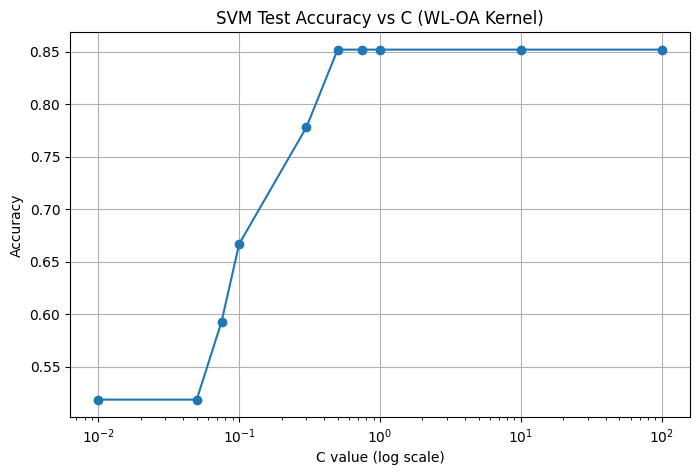

In [6]:
import matplotlib.pyplot as plt

# Sort C values numerically for cleaner plotting
sorted_C = sorted(results.keys())
accuracies = [results[C] for C in sorted_C]

plt.figure(figsize=(8,5))
plt.plot(sorted_C, accuracies, marker='o')
plt.xscale('log')                     # C spans several magnitudes
plt.xlabel("C value (log scale)")
plt.ylabel("Accuracy")
plt.title("SVM Test Accuracy vs C (WL-OA Kernel)")
plt.grid(True)
plt.show()


In [7]:
# ---------------------------
# Proper Train / Val / Test Setup 
# ---------------------------

print(f"--- STARTING TRAINING ON {len(subgraphs)} SUBGRAPHS ---")

# 1. Outer Train/Test Split
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

subgraphs_arr = np.array(subgraphs, dtype=object)
labels_arr = np.array(labels)
groups_arr = np.array(groups)

train_idx, test_idx = next(sgkf.split(subgraphs_arr, labels_arr, groups_arr))

X_train = subgraphs_arr[train_idx]
X_test  = subgraphs_arr[test_idx]
y_train = labels_arr[train_idx]
y_test  = labels_arr[test_idx]

print(f"Train size: {len(X_train)} | Test size: {len(X_test)}")


# 2. WL-OA Kernel
print("Initializing WL-OA Kernel...")
gk = WeisfeilerLehmanOptimalAssignment(n_iter=2, normalize=True, n_jobs=-1)

# Train kernel matrix
print("Computing Training Kernel Matrix...")
K_train_full = gk.fit_transform(X_train)

# Test kernel matrix
print("Computing Test Kernel Matrix...")
K_test = gk.transform(X_test)


# ---------------------------
# 3. Hyperparameter Tuning on TRAINING SET ONLY (Inner CV)
# ---------------------------

C_values = [0.01, 0.05, 0.075, 0.1, 0.3, 0.5, 0.75, 1, 10, 100]
weights   = {'Disordered': 1, 'fcc': 2, 'bcc': 2, 'hcp': 2, 'sc': 2}

inner_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=RANDOM_SEED)

print("\n--- INNER CV HYPERPARAMETER SEARCH (NO TEST DATA USED) ---")

best_C = None
best_val_acc = -1

for C in C_values:
    val_scores = []

    # Inner Validation Loop
    for tr_idx, val_idx in inner_cv.split(X_train, y_train, groups_arr[train_idx]):

        # Slice kernel matrices for inner split
        K_tr = K_train_full[tr_idx][:, tr_idx]
        K_val = K_train_full[val_idx][:, tr_idx]

        y_tr = y_train[tr_idx]
        y_val = y_train[val_idx]

        clf = SVC(kernel='precomputed', C=C, class_weight=weights)
        clf.fit(K_tr, y_tr)

        y_pred_val = clf.predict(K_val)
        val_scores.append(accuracy_score(y_val, y_pred_val))

    mean_acc = np.mean(val_scores)
    print(f"C={C:<6} -> Mean Val Accuracy: {mean_acc:.4f}")

    if mean_acc > best_val_acc:
        best_val_acc = mean_acc
        best_C = C

print(f"\nBest C from INNER CV = {best_C} (Val Acc = {best_val_acc:.4f})")


# ---------------------------
# 4. Train Final Model on FULL Training Set With Best C
# ---------------------------

print(f"\nTraining FINAL model on full training set (C={best_C})...")
final_clf = SVC(kernel='precomputed', C=best_C, class_weight=weights)
final_clf.fit(K_train_full, y_train)

# ---------------------------
# 5. Evaluate Once on Test Set
# ---------------------------

print("\nPredicting on Test Set...")
y_pred_test = final_clf.predict(K_test)

print("\n--- FINAL TEST RESULTS ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_test))


--- STARTING TRAINING ON 396 SUBGRAPHS ---
Train size: 315 | Test size: 81
Initializing WL-OA Kernel...
Computing Training Kernel Matrix...
Computing Test Kernel Matrix...

--- INNER CV HYPERPARAMETER SEARCH (NO TEST DATA USED) ---
C=0.01   -> Mean Val Accuracy: 0.5527
C=0.05   -> Mean Val Accuracy: 0.5527
C=0.075  -> Mean Val Accuracy: 0.5905
C=0.1    -> Mean Val Accuracy: 0.6571
C=0.3    -> Mean Val Accuracy: 0.8002
C=0.5    -> Mean Val Accuracy: 0.8291
C=0.75   -> Mean Val Accuracy: 0.8387
C=1      -> Mean Val Accuracy: 0.8387
C=10     -> Mean Val Accuracy: 0.8387
C=100    -> Mean Val Accuracy: 0.8387

Best C from INNER CV = 0.75 (Val Acc = 0.8387)

Training FINAL model on full training set (C=0.75)...

Predicting on Test Set...

--- FINAL TEST RESULTS ---
Accuracy: 0.8519

Detailed Classification Report:
              precision    recall  f1-score   support

  Disordered       0.78      1.00      0.88        42
         bcc       1.00      0.67      0.80         9
         fcc     